#WeatherBench Evaluation

# **I-GOOGLE ACCOUNT AUTHENTIFICATION**

In [1]:
from google.colab import auth
auth.authenticate_user()


# **II-IMPORT THE REQUIREMENTS LIBRARIES**

In [ ]:
# !pip install cupy
# import cupy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
! pip install -q -U zarr xarray gcsfs
import xarray as xr
import gcsfs
import zarr
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



In [ ]:

# define the neuralgcm path data
ngcm_path = 'gs://neuralgcm/amip_runs/v1_precip_stochastic_2_8_deg/2001-to-2021_128x64_gauss_37-level_stride3h.zarr'
#load the data
# ngcm_data = xr.open_zarr(ngcm_path,chunks={"time":100})
ngcm_data = xr.open_zarr(ngcm_path)

<ipython-input-27-cd22bc7a61c8>:5: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ngcm_data = xr.open_zarr(ngcm_path)


In [ ]:
#the size of the neural gcm data
ngcm_data.nbytes/1e9

1628.740724872

In [ ]:
print(list(ngcm_data.data_vars))

['evaporation', 'geopotential', 'precipitation_cumulative_mean', 'specific_cloud_ice_water_content', 'specific_cloud_liquid_water_content', 'specific_humidity', 'temperature', 'u_component_of_wind', 'v_component_of_wind']


# **Data Understanding**

In [ ]:
ngcm_data.precipitation_cumulative_mean


<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 128,
                                                   latitude: 64)> Size: 71GB
dask.array<open_dataset-precipitation_cumulative_mean, shape=(37, 58408, 1, 128, 64), dtype=float32, chunksize=(1, 8, 1, 128, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

In [ ]:
#Calculate the exact range of days covered by NeuralGCM.
import pandas as pd

base_date = pd.Timestamp(ngcm_data.time.max().values)
offset = pd.Timedelta(days=7300, hours=21)
final_date = base_date + offset

print(final_date)


2021-12-22 21:00:00


# **neuralGCM data for our domain**

In [ ]:
#select Horn Africa data
ngcm_data_africa = ngcm_data.sel(latitude=slice(-20,30),longitude=slice(15,60))


In [ ]:
ngcm_data_africa

<xarray.Dataset> Size: 57GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 58408,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 467kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 2GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
!pip install cartopy

Longitude shape: (16,)
Latitude shape: (18,)
Data shape: (16, 18)


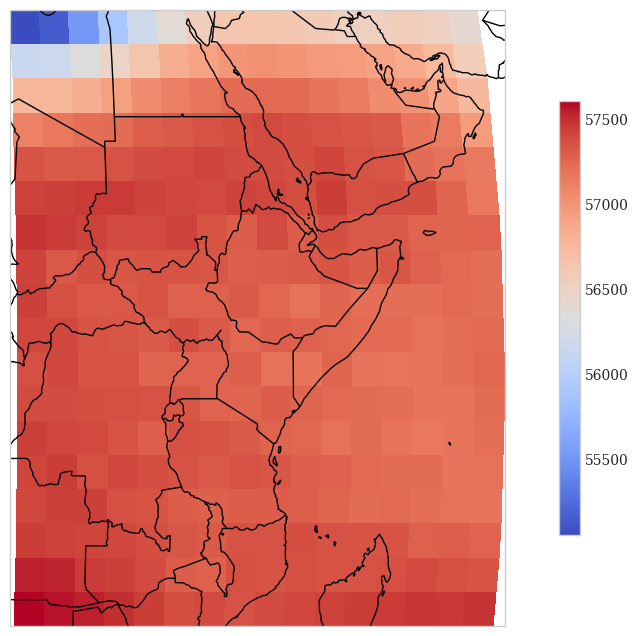

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

fig = plt.figure(figsize=(14,8))
ax = plt.axes(projection=ccrs.Robinson())

lons = ngcm_data_africa.longitude.values
lats = ngcm_data_africa.latitude.values
print(f"Longitude shape: {lons.shape}")
print(f"Latitude shape: {lats.shape}")

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=1)
# Compute the mean along the 'prediction_timedelta' dimension
geopotential_mean = ngcm_data_africa.geopotential.isel({'time':0,'level':0,'prediction_timedelta':ngcm_data_africa.prediction_timedelta[0]}).values
print(f"Data shape: {geopotential_mean.shape}")
c = plt.pcolormesh(lons, lats, geopotential_mean.T, transform=ccrs.PlateCarree(), cmap='coolwarm',shading='nearest')

cb = plt.colorbar(c, fraction=0.02)


In [ ]:
# Identify precipitation variable name (commonly 'tp' or 'precip')
precip_name = [var for var in ngcm_data_africa.data_vars if 'precip' in var or 'tp' in var][0]
precip = ngcm_data_africa[precip_name]
precip

<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 16,
                                                   latitude: 18)> Size: 2GB
dask.array<getitem, shape=(37, 58408, 1, 16, 18), dtype=float32, chunksize=(1, 8, 1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

In [ ]:
#the size of the horn africa data in GO
ngcm_data_africa.nbytes/1e9

57.26086748

In [ ]:
#the prediction time
ngcm_data_africa.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

# we can now selected the 6h time delta

In [ ]:
#select the climate timeset where prediction_timedelta is a multiple of 6h

# Convert prediction_timedelta to a pandas Series for easier manipulation
prediction_timedelta_series = pd.Series(ngcm_data_africa.prediction_timedelta.values)

# Select values where prediction_timedelta is a multiple of 6 hours (in seconds)
selected_indices = prediction_timedelta_series[prediction_timedelta_series % pd.Timedelta(hours=6) == pd.Timedelta(0)].index

# Use the selected indices to filter the entire dataset
selected_data = ngcm_data_africa.isel(prediction_timedelta=selected_indices)

selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
selected_data.nbytes/1e9

28.63043404

In [ ]:
print(selected_data.info())

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 29204 ;
	surface = 1 ;
	longitude = 16 ;
	latitude = 18 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_of

In [ ]:
selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2